In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

from Bio import SeqIO

import pandas as pd

from bokeh.transform import jitter, factor_cmap
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import Legend, Range1d, LabelSet, Span
from bokeh.io import export_png
from bokeh.palettes import brewer

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np

from os import listdir
from os.path import isfile, join

import scipy
from scipy import stats

import pickle

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, Bidirectional
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
output_notebook()

Loading BokehJS ...

### Generating dataframe to build nucleotide calling model:

In [2]:
# Function to convert abi files to dataframes for use:
def abi_to_df(input_seqio_record):
    # Getting the list of letters and their locations:
    locations = list(input_seqio_record.annotations['abif_raw']['PLOC1'])
    letters = list(input_seqio_record.annotations['abif_raw']['PBAS1'])
    
    # Converting to df:
    letter_loc_df = pd.DataFrame()
    letter_loc_df['Locations'] = locations
    letter_loc_df['Letters'] = letters
    
    # Different df with all the waveform data:
    peak_df = pd.DataFrame()
    peak_df['g_let'] = list(input_seqio_record.annotations['abif_raw']['DATA9'])
    peak_df['a_let'] = list(input_seqio_record.annotations['abif_raw']['DATA10'])
    peak_df['t_let'] = list(input_seqio_record.annotations['abif_raw']['DATA11'])
    peak_df['c_let'] = list(input_seqio_record.annotations['abif_raw']['DATA12'])
    
    # Making the indeces play nicely and deleting the other column:
    peak_df['index_plus_one'] = peak_df.index + 1
    peak_df.index = peak_df['index_plus_one']
    letter_loc_df.index = letter_loc_df['Locations']
    letter_loc_df.drop('Locations', inplace=True, axis=1)

    # combining the dfs:
    combined_df = letter_loc_df.join(peak_df, how='inner')
    
    return combined_df

Example resulting dataframe:

In [17]:
# Read in abi record:
input_ab1 = SeqIO.read('./ab1_dir/gata2_31_200bpprom.custom2.ab1', 'abi')
# Convert to dataframe:
test_df = abi_to_df(input_ab1)
test_df.head(10)

,Letters,g_let,a_let,t_let,c_let,index_plus_one
41,C,287,34,0,430,41
51,T,25,6,439,131,51
61,T,5,0,534,245,61
75,T,0,24,608,9,75
86,T,128,231,671,3,86
96,G,289,4,220,5,96
106,T,1,11,400,13,106
118,T,0,27,489,0,118
130,T,0,6,468,0,130
144,G,398,0,305,6,144


In [ ]:
# Loading in the file names
mypath = './massive_training_set/ab1s/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for idx, each_file in enumerate(onlyfiles):
    current_record = SeqIO.read('./massive_training_set/ab1s/%s' % each_file, 'abi')
    current_training_df = abi_to_df(current_record)
    current_training_df['saving_og'] = current_training_df['Letters']
    current_training_df.to_csv('./massive_training_set/nucleotide_dfs/%s.csv' % str(each_file.rsplit('.', 1)[0]), index=False)

### Generating dataframe to build peak calling model:

In [15]:
# A few more required functions:

# Adding the previous and the following base to the df:
def surrounding_bases(input_df):
    previous_letter_value_df = input_df.shift(1)
    previous_letter_value_df.dropna(inplace=True)
    previous_letter_value_df.rename({'a_let':'prev_a','c_let':'prev_c','t_let':'prev_t','g_let':'prev_g'}, inplace=True, axis=1)

    following_letter_value_df = input_df.shift(-1)
    following_letter_value_df.dropna(inplace=True)
    following_letter_value_df.rename({'a_let':'next_a','c_let':'next_c','t_let':'next_t','g_let':'next_g'}, inplace=True, axis=1)

    current_previous_following_df = pd.concat([input_df, previous_letter_value_df, following_letter_value_df], axis=1, join='inner')
    return current_previous_following_df

# Just reading in all the waverform data
def for_peak_prediction(input_seqio_record):
    # Different df with all the waveform data:
    peak_val = pd.DataFrame()
    peak_val['g_let'] = list(input_seqio_record.annotations['abif_raw']['DATA9'])
    peak_val['a_let'] = list(input_seqio_record.annotations['abif_raw']['DATA10'])
    peak_val['t_let'] = list(input_seqio_record.annotations['abif_raw']['DATA11'])
    peak_val['c_let'] = list(input_seqio_record.annotations['abif_raw']['DATA12'])
        
    return peak_val

# This combines a peak df with a full record
def peak_calling_df(input_df, input_seqio_record):
    input_df['peak_no_peak'] = [1] * input_df.shape[0]
    input_df.index = input_df.index + 1####MAYBE KEEP THIS IN? MAYBE REMOVE IT?
    first_val = input_df.index[0] - 5
    last_val = input_df.index[-1] + 5
    removed_df = input_df[['peak_no_peak']]
    # Different df with all the waveform data:
    peak_val = pd.DataFrame()
    peak_val['g_let'] = list(input_seqio_record.annotations['abif_raw']['DATA9'])
    peak_val['a_let'] = list(input_seqio_record.annotations['abif_raw']['DATA10'])
    peak_val['t_let'] = list(input_seqio_record.annotations['abif_raw']['DATA11'])
    peak_val['c_let'] = list(input_seqio_record.annotations['abif_raw']['DATA12'])
    
    peak_val = peak_val.loc[first_val:last_val]
    fin_df = removed_df.merge(peak_val, how='outer', left_index=True, right_index=True)
    zero = fin_df[fin_df['peak_no_peak'] !=1]
    zero['peak_no_peak'] = [0] * zero.shape[0]
    nonzero = fin_df[fin_df['peak_no_peak'] ==1]
    fin_df = zero.append(nonzero)
    fin_df.sort_index(inplace=True)

    return fin_df

def slope(inp_df):
    only_letters = inp_df[['g_let', 'a_let', 't_let', 'c_let']]
    slope_before = only_letters.diff(1, axis=0)
    slope_before.columns = ['slope_g_after', 'slope_a_after', 'slope_t_after', 'slope_c_after']
    slope_after = only_letters.diff(-1, axis=0)
    slope_after.columns = ['slope_g_before', 'slope_a_before', 'slope_t_before', 'slope_c_before']
    
    final = only_letters.join(slope_before)
    final = final.join(slope_after)
    final = final.join(inp_df[['peak_no_peak']])
    
    return final

def normalizing(inp_df):
    all_peak_places = inp_df[inp_df['peak_no_peak'] == 1]
    all_peak_places_vals = all_peak_places[['g_let', 'a_let', 't_let', 'c_let']]
    all_max_peaks = list(all_peak_places_vals.max(axis=1))
    trimmed_mean = scipy.stats.trim_mean(all_max_peaks, proportiontocut=0.1)
    inp_df = inp_df / trimmed_mean
    inp_df['peak_no_peak'] = inp_df['peak_no_peak'] * trimmed_mean
    inp_df['peak_no_peak'] = inp_df['peak_no_peak'].astype(int)
    return inp_df

def finding_taller_peak(the_input_df):
    # Getting all of the peaks:
    peaks = the_input_df[the_input_df['peak_no_peak'] == 1]
    # Getting the indeces of all of the peaks:
    peak_indeces = list(peaks.index)
    # Getting the surrounding four rows:
    before_peaks = [item - 4 for item in peak_indeces]
    after_peaks = [item + 4 for item in peak_indeces]
    # Going through each peak and respective rows:
    for idx, item in enumerate(before_peaks):
        # Making the smaller df:
        temp_df = the_input_df.loc[item:after_peaks[idx]]
        current_peak_loc = temp_df[temp_df['peak_no_peak'] == 1].index.tolist()[0]
        just_letts = temp_df[['g_let','a_let','t_let','c_let']]
        # Getting the max value of the dataframe:
        max_val = max(just_letts.max(axis=1))
        # Getting the index of the max value:
        max_idx = int(temp_df[temp_df.values == max_val].index.tolist()[0])
        max_letter = just_letts.loc[max_idx].idxmax(axis=1)

        # Acquiring the slopes:
        before_slopes = pd.DataFrame(temp_df.loc[max_idx][['slope_g_before','slope_a_before','slope_t_before','slope_c_before']]).T
        before_slopes.columns = ['g_let','a_let','t_let','c_let']
        after_slopes = pd.DataFrame(temp_df.loc[max_idx][['slope_g_after','slope_g_after','slope_g_after','slope_g_after']]).T
        after_slopes.columns = ['g_let','a_let','t_let','c_let']

        # If they're both positive:
        val_1 = before_slopes[[max_letter]].values >= 0
        val_1 = val_1[0][0]
        val_2 = after_slopes[[max_letter]].values >= 0
        val_2 = val_2[0][0]
        if val_1 and val_2:
            the_input_df['peak_no_peak'][current_peak_loc] = 0
            the_input_df['peak_no_peak'][max_idx] = 1     

    return the_input_df

In [18]:
# Reading in the ab1 file
sequence_record = SeqIO.read('./ab1_dir/gata2_31_200bpprom.custom2.ab1', 'abi')

# Generating the nucleotide dataframe, which will be important for nucleotide calling:
nucleotide_df = abi_to_df(sequence_record)

# To generate the dataframe of the peaks, we also use the nucleotide dataframe generated above:
nucleotide_df.set_index('index_plus_one', inplace=True)

# Generating the peak_df using the nucleotide dataframe:
peak_df = peak_calling_df(nucleotide_df, sequence_record)

# Example of the dataframe
peak_df.head(10)

/Users/alexandredaly/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,peak_no_peak,g_let,a_let,t_let,c_let
37,0.0,432,46,0,396
38,0.0,382,40,0,418
39,0.0,333,36,0,429
40,0.0,287,34,0,430
41,0.0,244,34,18,419
42,1.0,205,36,49,398
43,0.0,170,38,92,367
44,0.0,136,39,142,331
45,0.0,105,38,202,291
46,0.0,79,33,256,250


Cleaning up the dataframe a little bit:

In [ ]:
# Normalizing the value:
peak_df = normalizing(peak_df)

# A helpful feature is finding the slope before and after each location:
peak_df = slope(peak_df)

# It turns out that the peaks called in the ab1 file are often not the peaks - fixing this:
finding_taller_peak(peak_df)

# Writing the files to a csv:
finding_taller_peak.to_csv('./data/peak_files/peak_file_1.csv')

###### A quick aside: showing the reason peaks need to be 'fixed':

In [39]:
def vals_before_or_after(inp_df, val_to_check, return_peak_val=False):
    # Getting the peak values
    peaks = inp_df[inp_df['peak_no_peak'] == 1]
    peak_locs = list(peaks.index)
    just_letter_peaks = peaks[['g_let', 'a_let', 't_let', 'c_let']]
    peak_max_val = list(just_letter_peaks.max(axis=1))

    # Getting the values one before peak:
    one_bef_peak = [item + val_to_check for item in peak_locs]
    one_bef_df = inp_df.loc[one_bef_peak]
    just_letter_one_bef = one_bef_df[['g_let', 'a_let', 't_let', 'c_let']]
    one_bef_max_val = list(just_letter_one_bef.max(axis=1))
    
    if return_peak_val == True:
        return peak_max_val, one_bef_max_val
    else:
        return one_bef_max_val
    
def remove_nans(input_list):
    input_list = np.array(input_list)
    final_list = input_list[~np.isnan(input_list)]
    return final_list

In [35]:
# Reading in both fixed and unfixed peaks:
unfixed_path = './data/unfixed_peaks/'
fixed_path = './data/fixed_peaks/'

# The filenames are all the same:
filenames = [f for f in listdir(unfixed_path) if isfile(join(unfixed_path, f))]

fixed_df = pd.DataFrame()
unfixed_df = pd.DataFrame()
for idx, item in enumerate(filenames):
    
    # Opening the peak files:
    temp_fixed = pd.read_csv('%s%s' % (fixed_path, item), index_col=0)
    temp_unfixed = pd.read_csv('%s%s' % (unfixed_path, item), index_col=0)
    
    # I'm only training data on the files that have > 1000 peaks, so staying consistent:
    peaks = temp_fixed[temp_fixed['peak_no_peak'] == 1].shape[0] 
    
    if peaks < 1000:
        continue
    
    # Getting the data:
    fixed_df = fixed_df.append(temp_fixed)
    unfixed_df = unfixed_df.append(temp_unfixed)
    
    # Reindexing:
    fixed_df.reset_index(inplace=True, drop=True)
    unfixed_df.reset_index(inplace=True, drop=True)

In [40]:
# One before:
one_bef_max_val_fixed = vals_before_or_after(fixed_df, -1)
one_bef_max_val_fixed = remove_nans(one_bef_max_val_fixed)
# Two before:
two_bef_max_val_fixed = vals_before_or_after(fixed_df, -2)
two_bef_max_val_fixed = remove_nans(two_bef_max_val_fixed)

# One after:
one_aft_max_val_fixed = vals_before_or_after(fixed_df, 1)
one_aft_max_val_fixed = remove_nans(one_aft_max_val_fixed)
# Two after:
peak_list_fixed, two_aft_max_val_fixed = vals_before_or_after(fixed_df, 2, return_peak_val=True)
two_aft_max_val_fixed = remove_nans(two_aft_max_val_fixed)

peak_list_fixed = remove_nans(peak_list_fixed)

# One before:
one_bef_max_val_unfixed = vals_before_or_after(unfixed_df, -1)
one_bef_max_val_unfixed = remove_nans(one_bef_max_val_unfixed)
# Two before:
two_bef_max_val_unfixed = vals_before_or_after(unfixed_df, -2)
two_bef_max_val_unfixed = remove_nans(two_bef_max_val_unfixed)

# One after:
one_aft_max_val_unfixed = vals_before_or_after(unfixed_df, 1)
one_aft_max_val_unfixed = remove_nans(one_aft_max_val_unfixed)
# Two after:
peak_list_unfixed, two_aft_max_val_unfixed = vals_before_or_after(unfixed_df, 2, return_peak_val=True)
two_aft_max_val_unfixed = remove_nans(two_aft_max_val_unfixed)

peak_list_unfixed = remove_nans(peak_list_unfixed)

If the peaks are truly peaks, it would make sense for the peak values to be learger than the values around the peaks (the values one or two away from the peaks). Above I've collected the values for the peak, and also values around the peaks. Below shows some basic statistics concerning these values.

There is **no** statistically significant difference in value between peaks and the location immediately preceding the unfixed dataset: 

In [44]:
print(stats.ttest_ind(peak_list_unfixed, one_bef_max_val_unfixed))
print(stats.ttest_ind(peak_list_unfixed, two_bef_max_val_unfixed))
print(stats.ttest_ind(peak_list_unfixed, one_aft_max_val_unfixed))
print(stats.ttest_ind(peak_list_unfixed, two_aft_max_val_unfixed))

Ttest_indResult(statistic=-0.040668072386749146, pvalue=0.9675605954457309)
Ttest_indResult(statistic=21.544653589484465, pvalue=1.0135537630178583e-102)
Ttest_indResult(statistic=21.678101431726425, pvalue=5.707574598217427e-104)
Ttest_indResult(statistic=64.04771978175397, pvalue=0.0)


But there **is** a statistically significant difference between the peak and the preceding location in the fixed dataset:

In [45]:
print(stats.ttest_ind(peak_list_fixed, one_bef_max_val_fixed))
print(stats.ttest_ind(peak_list_fixed, two_bef_max_val_fixed))
print(stats.ttest_ind(peak_list_fixed, one_aft_max_val_fixed))
print(stats.ttest_ind(peak_list_fixed, two_aft_max_val_fixed))

Ttest_indResult(statistic=9.863928286164338, pvalue=6.111105860165287e-23)
Ttest_indResult(statistic=41.321722638055824, pvalue=0.0)
Ttest_indResult(statistic=11.75841375265852, pvalue=6.706368985940247e-32)
Ttest_indResult(statistic=44.70384963811799, pvalue=0.0)


Comparing the means for both datasets:

In [47]:
print(np.mean(peak_list_unfixed))
print(np.mean(one_bef_max_val_unfixed))
print(np.mean(two_bef_max_val_unfixed))
print(np.mean(one_aft_max_val_unfixed))
print(np.mean(two_aft_max_val_unfixed))
print('\n\n')
print(np.mean(peak_list_fixed))
print(np.mean(one_bef_max_val_fixed))
print(np.mean(two_bef_max_val_fixed))
print(np.mean(one_aft_max_val_fixed))
print(np.mean(two_aft_max_val_fixed))

1.0324283429362433
1.0325583225972772
0.9665951758173349
0.9659391438930929
0.8488926566523692



1.0490920627668103
1.0180408552804372
0.9263168518897866
1.0121686505409637
0.916809043693293


Clearly the mean of the fixed set is quite significant. The difference in distributions can be seen by plotting the values.

Unfixed:

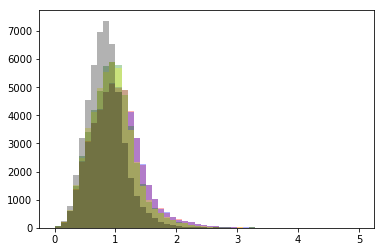

In [48]:
_ = plt.hist(peak_list_unfixed, alpha=0.3, color='red', bins=50, range=[0,5])
_ = plt.hist(one_bef_max_val_unfixed, alpha=0.3, color='blue', bins=50, range=[0,5])
_ = plt.hist(two_bef_max_val_unfixed, alpha=0.3, color='green', bins=50, range=[0,5])
_ = plt.hist(one_aft_max_val_unfixed, alpha=0.3, color='yellow', bins=50, range=[0,5])
_ = plt.hist(two_aft_max_val_unfixed, alpha=0.3, color='black', bins=50, range=[0,5])

Fixed:

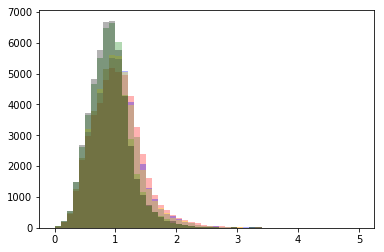

In [49]:
_ = plt.hist(peak_list_fixed, alpha=0.3, color='red', bins=50, range=[0,5])
_ = plt.hist(one_bef_max_val_fixed, alpha=0.3, color='blue', bins=50, range=[0,5])
_ = plt.hist(two_bef_max_val_fixed, alpha=0.3, color='green', bins=50, range=[0,5])
_ = plt.hist(one_aft_max_val_fixed, alpha=0.3, color='yellow', bins=50, range=[0,5])
_ = plt.hist(two_aft_max_val_fixed, alpha=0.3, color='black', bins=50, range=[0,5])

### Building and running nucleotide calling function:

In [ ]:
# Loading in the data:
mypath = './data/nucleotide_dfs/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
training_df = pd.DataFrame()
for item in onlyfiles:
    temp_training = pd.read_csv('%s%s' % (mypath, item))
    training_df = training_df.append(temp_training)

training_df.reset_index(inplace=True)

# Setting up the df columns:
letter_value_df = training_df[['a_let', 'c_let', 't_let', 'g_let']]
called_letter_df = training_df[['Letters']]

# Getting the info from previous and next base:
full_info_df = surrounding_bases(letter_value_df)
full_info_df = full_info_df.values.tolist()

# Dropping the first and last letters since their values get clipped
called_letter_df = called_letter_df[1:]
called_letter_df.drop(called_letter_df.tail(1).index,inplace=True)
called_letter_list = list(called_letter_df['Letters'])
called_letter_array = [[item] for item in called_letter_list]

# Running the model:
full_log_reg = linear_model.LogisticRegression(C=1,penalty='l2',solver='liblinear',tol=0.0001)

# Saving the model:
# pickle.dump(full_log_reg, open('log_reg_default_million.sav', 'wb'))

### Building and running peak calling function:

In [ ]:
def reshaping_the_df(inp_df, first_dim, second_dim, third_dim):
    y_val_train = np.array(inp_df['peak_no_peak'])
    inp_df = inp_df.iloc[:,:-1]
    x_val_train = inp_df.values.reshape((first_dim,second_dim,third_dim))
    return x_val_train, y_val_train    

In [ ]:
# Making the training df larger:
mypath = './data/fixed_peaks/'
df_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for idx, item in enumerate(df_files):
    
    # Opening the peak file
    temp_training = pd.read_csv('%s%s' % (mypath, item), index_col=0)
    
    # Counting how many peaks there are:
    how_many_peaks = temp_training[temp_training['peak_no_peak']==1].shape[0]
    
    # Drop the files that have fewer than 1000 peaks
    if how_many_peaks < 1000:
        continue
        
    # OPTIONAL - dropping the files that have fewer than 120000 peaks
    if temp_training.shape[0] < 12000:
        continue
        
    # Removing na rows (there's at least two in each df)
    temp_training.dropna(inplace=True)

    if idx == 0:
        final_df = temp_training
        
    else:
        final_df = final_df.append(temp_training)        
        
# Train-test splitting:
split_val = math.floor(float(final_df.shape[0]) * 0.8)
training_df = final_df[:split_val]
test_df = final_df[split_val:]

# Setting up the x and the y:
training_array_x, training_array_y = reshaping_the_df(training_df, training_df.shape[0], 1, 12)
testing_array_x, testing_array_y = reshaping_the_df(test_df, test_df.shape[0], 1, 12)

# Checking how many training and testing values we have:
print(training_array_x.shape)
print(testing_array_x.shape)

In [ ]:
# Running the model:
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', input_shape= (1,12),return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.fit(training_array_x,
          training_array_y,
          epochs=10,
          validation_data=(testing_array_x, testing_array_y))

# Saving the model:
# model.save('bidirectional_actual_all_data_model_10_5.h5') 

### Evaluating the model:

##### Looking at how peaks are called:

In [13]:
input_df = pd.read_csv('./data/peak_files/bidirectional_prediction_alldata_df_10_5_19.csv', index_col=0)
input_df['x_axis_loc'] = list(input_df.index)

# Just predicted peaks:
peak_locs = input_df[input_df['predicted_peaks'] == 1]
peak_locs_list = list(peak_locs.index)

# Actual peaks:
act_peak_locs = input_df[input_df['peak_no_peak'] == 1]
act_peak_locs = act_peak_locs[['g_let','a_let','t_let','c_let']]
name_dict = {'g_let':'G','a_let':'A','t_let':'T','c_let':'C'}
act_peak_locs['max_let'] = act_peak_locs.idxmax(axis=1)
act_peak_locs['nuc_peak'] = act_peak_locs['max_let'].map(name_dict)
act_peak_locs['x_axis_loc'] = list(act_peak_locs.index)


source = ColumnDataSource(input_df)
source_2 = ColumnDataSource(act_peak_locs)

x_start = min(list(input_df['x_axis_loc']))
x_stop = max(list(input_df['x_axis_loc']))
traces = figure(plot_width=15000, plot_height=400, x_range=[x_start, x_stop])

traces.line(x='x_axis_loc', y='g_let', line_width=2, color='yellow', source=source)
traces.line(x='x_axis_loc', y='a_let', line_width=2, color='red', source=source)
traces.line(x='x_axis_loc', y='t_let', line_width=2, color='green', source=source)
traces.line(x='x_axis_loc', y='c_let', line_width=2, color='blue', source=source)


labels = LabelSet(x='x_axis_loc', y=2.5, text='nuc_peak', level='glyph',
                  source=source_2, render_mode='canvas')

v_line_dict = {}
for item in peak_locs_list:
    v_line_dict[item] = Span(location=item, dimension='height', line_color='black', line_width=1)


traces.background_fill_color = "white"
traces.xaxis.axis_label_text_font_size = "16pt"
traces.xaxis.major_label_text_font_size = "12pt"
traces.yaxis.major_label_text_font_size = "12pt"
traces.yaxis.axis_label_text_font_size = "16pt"
traces.toolbar.logo = None
traces.toolbar_location = None
traces.xgrid.grid_line_color = None
traces.ygrid.grid_line_color = None

traces.add_layout(labels)

traces.renderers.extend(v_line_dict.values())


_ = show(traces)

##### More stats:

### Miscellaneous questions/problems:

Seeing if there's an enrichment of miscalled peaks with a given letter:

In [14]:
# Putting the correct nucleotide at each peak:
just_letters_df = input_df[input_df['peak_no_peak'] == 1][['g_let', 'a_let', 't_let', 'c_let']]
just_letters_df['peak_nuc'] = just_letters_df.idxmax(axis=1)
letter_dict = {'g_let':'G','a_let':'A','t_let':'T','c_let':'C'}
just_letters_df['correct_peak_nuc'] = just_letters_df['peak_nuc'].map(letter_dict)
input_df['correct_peak_nuc'] = just_letters_df['correct_peak_nuc']

# Seeing if there's an enrichment of incorrect nucleotides:
og_peak_df = input_df[input_df['peak_no_peak'] == 1]
incorrect_og_peak = og_peak_df[og_peak_df['predicted_peaks'] == 0]

letter_count_dict = {}
for each_letter in list(incorrect_og_peak['correct_peak_nuc']):
    try:
        letter_count_dict[each_letter] += 1
    except:
        letter_count_dict[each_letter] = 1

letter_count_dict

{'A': 65, 'C': 22, 'G': 7, 'T': 38}

A's and T's consistently underperform all the other letters. Checking whether that's because it's underrepresented in the training set:

In [15]:
# Making the training df larger:
mypath = './data/nucleotide_dfs/'
df_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

g_values = []
a_values = []
c_values = []
t_values = []
n_values = []
for idx, item in enumerate(df_files):
#     if idx == 100:
#         break
    
    temp_training = pd.read_csv('%s%s' % (mypath, item), index_col=0)
    
    if temp_training.shape[0] < 1000:
        continue
    
    a_df = temp_training[temp_training['saving_og'] == 'A']
    a_values.append(a_df.shape[0])
                    
    g_df = temp_training[temp_training['saving_og'] == 'G']
    g_values.append(g_df.shape[0])
                    
    t_df = temp_training[temp_training['saving_og'] == 'T']
    t_values.append(t_df.shape[0])
                    
    c_df = temp_training[temp_training['saving_og'] == 'C']
    c_values.append(c_df.shape[0])
                    
    n_df = temp_training[temp_training['saving_og'] == 'N']
    n_values.append(n_df.shape[0])

In [16]:
print(np.mean(g_values))
print(np.mean(a_values))
print(np.mean(t_values))
print(np.mean(c_values))
print(np.mean(n_values))

291.85869565217394
302.6195652173913
300.14130434782606
300.04347826086956
56.119565217391305


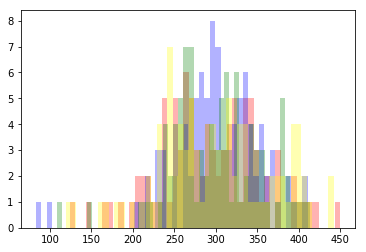

In [17]:
_ = plt.hist(g_values, alpha=0.3, color='red', bins=50)
_ = plt.hist(a_values, alpha=0.3, color='blue', bins=50)
_ = plt.hist(t_values, alpha=0.3, color='green', bins=50)
_ = plt.hist(c_values, alpha=0.3, color='yellow', bins=50)

Interestingly, A is the most common letter...so clearly it's well represented...this could mean though that if errors are randomly distributed, it would more frequently end up being an A?